# Notebook 2: modélisation

Ce notebook contient la phase de modélisaiton du projet 2 du parcours Ingénieur Machine Learning d'OpenClassrooms.

Le notebook numéro 1 contient la phase de nettoyage et d'analyse exploratoire, ainsi qu'une préselection des features et la majorité du feature engineering.

## Objectifs et problématique

Les objectifs de ce notebook sont:

- entrainer plusieurs types de modèles de régression et comparer leurs performances. Nous avons deux variables à prédire: 
  - SiteEnergyUse(kBtu) : la consommation en énergie de chaque propriété
  - TotalGHGEmissions : les emissions de gaz a effet de serre de chaque propriété 

- choisir les meilleurs features pour entrainer notre modèle

- choisir un modèle pour chaque variable à prédire, puis optimiser ce modèle  (trouver de meilleurs hyperparamètres)

- juger de l'utilité de l'ENERGYSTARScore pour prédire TotalGHGEmissions (cet indicateur étant fastidieux et couteux à calculer)



*Nb. Ce projet s'inscrit dans l'objectif plus global de faire de Seattle une ville neutre en émissions de carbone d'ici 2050.*






# Chargement des données

In [ ]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set la random seed
random.seed(1337)
np.random.seed(1337)

In [ ]:
# Chargement du dataset
df = pd.read_csv('drive/MyDrive/Pélec/df_seattle.csv')

In [ ]:
# Informations sur le dataset (colonnes, dtypes, nulls...)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Data columns (total 87 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   OSEBuildingID                                              1622 non-null   int64  
 1   Neighborhood                                               1622 non-null   object 
 2   NumberofBuildings                                          1622 non-null   float64
 3   NumberofFloors                                             1622 non-null   float64
 4   PropertyGFATotal                                           1622 non-null   int64  
 5   PropertyGFAParking                                         1622 non-null   int64  
 6   PropertyGFABuilding(s)                                     1622 non-null   int64  
 7   LargestPropertyUseType                                     1622 non-null   object 
 8   LargestP

In [ ]:
# Valeurs uniques
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Non-Refrigerated Warehouse', 'Other - Mall',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Distribution Center', 'Parking', 'Multifamily Housing',
       'Worship Facility', 'Restaurant', 'Data Center', 'Laboratory',
       'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Other

In [ ]:
# Déclaration des variables catégorielles
df['Neighborhood'] = df['Neighborhood'].astype(object)
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].astype(object)
df['MoreThanOneBuilding'] = df['MoreThanOneBuilding'].astype(object)
df['MoreThanOneFloor'] = df['MoreThanOneFloor'].astype(object)
df['MoreThanOneUse'] = df['MoreThanOneUse'].astype(object)
df['HasParking'] = df['HasParking'].astype(object)

In [ ]:
# Chargement des librairies
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from yellowbrick.regressor import ResidualsPlot, prediction_error

# Groupes de variables

In [ ]:
# Déclaration des features en différents groupes à comparer
Commun = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'Age']

# Features discrétisées
Continues = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking']
Dummies = ['MoreThanOneBuilding', 'MoreThanOneFloor', 'HasParking']

# Features de localisation
Neighborhood = ['Neighborhood']
Lon_lat = ['Longitude', 'Latitude']

# Usage principal et variable complémentaires vs. surfaces de tous les usages
LargestUsage = ['LargestPropertyUseType'] # Justifier l'utilisation avec les correlations
LargestUsageGFA = ['LargestPropertyUseTypeGFA']
MoreThanOneUse = ['MoreThanOneUse']
UGFA = [item for item in df.columns if item.startswith('UGFA_')]

# ENERGYSTARScore
ENERGYSTARScore = ['ENERGYSTARScore']




# Preprocessings à appliquer à chaque feature si présente dans le training set
var_OHE = ['MoreThanOneBuilding', 'MoreThanOneFloor', 'MoreThanOneUse', 'HasParking', 'LargestPropertyUseType', 'Neighborhood']
var_cont = ['Age'] + Lon_lat + ENERGYSTARScore + UGFA
var_log = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']

In [ ]:
# Drop des variables à prédire et de l'ID de la propriété
X = df.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'OSEBuildingID'] ,axis=1)

# Variables à prédire
y_GHE = df['TotalGHGEmissions']
y_En = df['SiteEnergyUse(kBtu)']

# Prédiction des emissions de gaz à effet de serre

## Split des données: jeux d'entrainement et de test

In [ ]:
# Constitution du set d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X,y_GHE, test_size=0.2, 
                                                    #stratify=X["discretized_GFATotal"], 
                                                    random_state=42)

# Log des variables à expliquer
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

## Pipeline

Ci-dessous la création d'une fonction/pipeline qui nous permettra pour les deux taches de prédiction d'itérer sur différents modèles, différentes features et différentes transformations de features.

In [ ]:
def train_test_cv(X_train, selection, y_train, model, log_tr, df_to_append, label):
    """
    Fonction entrainant un model de régression par cross validation (k=5) et output
    les moyennes d'un set de métrics.
    Append ces moyennes dans un dataframe, ainsi que la sélection de variables
    Input: X_train, sélection de colonnes, y_train, liste de modèles instanciés, log-transformation d'un subset de colonnes (True ou False), dataframe où output les metriques, passer un commentaire dans une colonne du DF

    Output in df_metrics: r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error , features utilisées, labels synthétisant les features
    """

    # Defini les colonnes de la sélection à log-transformer, scaler et onehotencoder
    to_var_log = list(np.intersect1d(var_log,X_train[selection].columns))
    to_var_OHE = list(np.intersect1d(var_OHE,X_train[selection].columns))
    to_var_cont = list(np.intersect1d(var_cont,X_train[selection].columns))

    # Détermine si la log transformation s'applique ou non
    if log_tr is False:
      to_var_cont = to_var_cont + to_var_log
      to_var_log = []

    else:
      pass

    # Log transforme et scale une selection de colonnes
    # Passage non affecté des autres colonnes
    log_scaler = Pipeline([
                       ('log_transformer', FunctionTransformer(np.log1p)),
                       ('scaler', StandardScaler())
                       ])

    # OHE sur une sélection de colonnes
    # StandardScaler sur une selection de colonnes
    # Log-transformation et StandardScaler sur une selection de colonnes
    # Drop des colonnes non spécifiées
    OHE_log_StandardScaler = ColumnTransformer(transformers=[
                                                    ('OHE', OneHotEncoder(drop='if_binary', sparse=False), to_var_OHE),
                                                    ('SCALER', StandardScaler(), to_var_cont),
                                                    ('LOG_SCALER', log_scaler, to_var_log)
                                                    ], remainder='drop')

    # Imputation par KNN
    imputer = KNNImputer(n_neighbors=5)

    # Assemblage du pipeline de preprocessing
    preprocessing_pipeline = Pipeline([
          ('OHE_log_StandardScaler', OHE_log_StandardScaler),
          ('imputer', imputer)
      ])

    # Fit et application du pipeline
    X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train[selection])

    # Training du model par cross validation et calculs des metrics
    cv_results = cross_validate(model, X_train_preprocessed, y_train, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'), cv=5, return_train_score=False)

    # Dictionnaire des metrics calculées
    metrics = {'Model' : locals()['model'],
              'Features' : locals()['selection'],
              'label': label,
              'Log Transformation' : locals()['log_tr'],
              'R²': np.mean(cv_results['test_r2'].round(3)), 
              'neg_mean_squared_error': np.mean(cv_results['test_neg_mean_squared_error'].round(3)), 
              'neg_mean_absolute_error': np.mean(cv_results['test_neg_mean_absolute_error'].round(3)), 
              'neg_mean_absolute_percentage_error': np.mean(cv_results['test_neg_mean_absolute_percentage_error'].round(3)),
              'fit_time': np.mean(cv_results['fit_time'].round(3))
              }
    
    # Append le dataframe
    global df_metrics

    df_metrics = df_metrics.append(metrics, ignore_index=True)

    return metrics


## Recherche du meilleur modèle

Mettons en place des listes et dictionnaires pour créer une boucle nous permettant de comparer toutes les combinaisons de features et modèles (sans tunning d'hyperparamètres pour l'instant) que nous souhaitons tester:

In [ ]:
# Defini les models
LR = LinearRegression()
Ridge_reg = Ridge(random_state=1337)
Lasso_reg = Lasso(random_state=1337)
ElasticNet = ElasticNet(random_state=1337)
SVR = SVR()
RF = RandomForestRegressor(random_state=1337)
XGB = xgb.XGBRegressor(random_state=1337)

# Liste des models
model_list = [LR, Ridge_reg, Lasso_reg, ElasticNet, RF, XGB]

Cette liste va nous permettre de boucler sur tous les modèles instanciés.

In [ ]:
# Options/sets de features à comparer
Cont_vs_dummies = {"Continues" : Continues, 
                   "Dummies" : Dummies}

Geo_var = {"Neighborhood" : Neighborhood, 
           "Lon_lat" : Lon_lat}

UGFA_vs_largestusage = {"UGFA" : UGFA,
                        "LargestUsage" : LargestUsage+LargestUsageGFA+MoreThanOneUse}

ESScore =  {"ENERGYSTARScore" : ENERGYSTARScore, 
            "No_ENERGYSTARScore" : []} 

log_tran = {"log_True" : True, 
            "log_False" : False}     


Ces dictionnaires vont nous permettre de comparer et tester toutes les combinaisons de:
- variables continues vs. leurs équivalent dummy
- différentes variables de localisation
- les surfaces par utilisation de la propriété issus du notebook de préparation des datas vs. un set plus simple de variables (OneHotEncoding de l'utilisation principale, sa surface, et si le batiment a d'autres utilisations)
- La présence ou non de l'ENERGYSTARScore dans les features
- la log-transformation ou non de certaines variables explicatives

In [ ]:
# Instancie le Dataframe à append par la fonction train_test_cv
df_metrics = pd.DataFrame()

# Loop sur toutes les options prédéfinies
for model in model_list:
  for label_a, a in Cont_vs_dummies.items():
    for label_b, b in Geo_var.items():
      for label_c, c in UGFA_vs_largestusage.items():
        for label_d, d in ESScore.items():
          for label_e, e in log_tran.items():
            train_test_cv(X_train, Commun+a+b+c+d, y_train, model, e, df_metrics, '_'.join([label_a, label_b, label_c, label_d]))

[22:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# Display le dataframe contenant les paramètres et métriques (du meilleur au moins bon) de tous les modèles entrainés
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_metrics.sort_values(by=['neg_mean_absolute_error'], ascending=False)

,Features,Log Transformation,Model,R²,fit_time,label,neg_mean_absolute_error,neg_mean_absolute_percentage_error,neg_mean_squared_error
60,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),5.932000e-01,0.0030,Dummies_Lon_lat_LargestUsage_ENERGYSTARScore,-7.124000e-01,-2.464000e-01,-8.290000e-01
52,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),5.926000e-01,0.0092,Dummies_Neighborhood_LargestUsage_ENERGYSTARScore,-7.134000e-01,-2.470000e-01,-8.308000e-01
36,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),5.898000e-01,0.0112,Continues_Neighborhood_LargestUsage_ENERGYSTAR...,-7.184000e-01,-2.486000e-01,-8.356000e-01
44,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),5.910000e-01,0.0040,Continues_Lon_lat_LargestUsage_ENERGYSTARScore,-7.184000e-01,-2.486000e-01,-8.332000e-01
165,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",0.0,XGBRegressor(random_state=1337),5.968000e-01,0.2082,Continues_Neighborhood_LargestUsage_ENERGYSTAR...,-7.188000e-01,-2.498000e-01,-8.234000e-01
180,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),5.896000e-01,0.2056,Dummies_Neighborhood_LargestUsage_ENERGYSTARScore,-7.232000e-01,-2.512000e-01,-8.370000e-01
181,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",0.0,XGBRegressor(random_state=1337),5.922000e-01,0.2046,Dummies_Neighborhood_LargestUsage_ENERGYSTARScore,-7.246000e-01,-2.514000e-01,-8.308000e-01
164,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),5.904000e-01,0.2028,Continues_Neighborhood_LargestUsage_ENERGYSTAR...,-7.258000e-01,-2.540000e-01,-8.360000e-01
172,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),5.846000e-01,0.1882,Continues_Lon_lat_LargestUsage_ENERGYSTARScore,-7.286000e-01,-2.548000e-01,-8.472000e-01
189,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",0.0,XGBRegressor(random_state=1337),5.834000e-01,0.1854,Dummies_Lon_lat_LargestUsage_ENERGYSTARScore,-7.320000e-01,-2.542000e-01,-8.494000e-01


- Tous les modèles linaires performent mieux en moyenne après log-transformation d'un set de features n'étant pas normalement distribuées (particulièrement les régression Ridge et Elasticnet)
- La regression Ridge outperform même les modèles ensemblistes non linéaires (XGBoost et RandomForest)
- La log-transformation ne semble pas avoir d'impact significatif sur ces modèles ensemblistes

In [ ]:
# Dataframe pour la présentation
df_metrics_ppt = df_metrics[['Model', 'label', 'Log Transformation', 'neg_mean_absolute_error', 'fit_time']].sort_values(by=['neg_mean_absolute_error'], ascending=False)
df_metrics_ppt

,Model,label,Log Transformation,neg_mean_absolute_error,fit_time
60,Ridge(random_state=1337),Dummies_Lon_lat_LargestUsage_ENERGYSTARScore,1.0,-7.124000e-01,0.0030
52,Ridge(random_state=1337),Dummies_Neighborhood_LargestUsage_ENERGYSTARScore,1.0,-7.134000e-01,0.0092
36,Ridge(random_state=1337),Continues_Neighborhood_LargestUsage_ENERGYSTAR...,1.0,-7.184000e-01,0.0112
44,Ridge(random_state=1337),Continues_Lon_lat_LargestUsage_ENERGYSTARScore,1.0,-7.184000e-01,0.0040
165,XGBRegressor(random_state=1337),Continues_Neighborhood_LargestUsage_ENERGYSTAR...,0.0,-7.188000e-01,0.2082
180,XGBRegressor(random_state=1337),Dummies_Neighborhood_LargestUsage_ENERGYSTARScore,1.0,-7.232000e-01,0.2056
181,XGBRegressor(random_state=1337),Dummies_Neighborhood_LargestUsage_ENERGYSTARScore,0.0,-7.246000e-01,0.2046
164,XGBRegressor(random_state=1337),Continues_Neighborhood_LargestUsage_ENERGYSTAR...,1.0,-7.258000e-01,0.2028
172,XGBRegressor(random_state=1337),Continues_Lon_lat_LargestUsage_ENERGYSTARScore,1.0,-7.286000e-01,0.1882
189,XGBRegressor(random_state=1337),Dummies_Lon_lat_LargestUsage_ENERGYSTARScore,0.0,-7.320000e-01,0.1854


## Ridge regression

Nous allons chercher une meilleure valeure du seul hyperparamètre (alpha) du modèle offrant la meilleur performance "out-of-the-box" avec une GridSearch et une cross-validation à 5 folds.

### Optimisation des hyperparamètres

In [ ]:
# Features utilisées dans le modèle le plus performant
df_metrics.loc[60]['Features']

['PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'Age',
 'MoreThanOneBuilding',
 'MoreThanOneFloor',
 'HasParking',
 'Longitude',
 'Latitude',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'MoreThanOneUse',
 'ENERGYSTARScore']

In [ ]:
# Defini la selection de features
selection = df_metrics.loc[60]['Features']


# Defini les colonnes de la sélection à log-transformer, scaler et onehotencoder
to_var_log = list(np.intersect1d(var_log,X_train[selection].columns))
to_var_OHE = list(np.intersect1d(var_OHE,X_train[selection].columns))
to_var_cont = list(np.intersect1d(var_cont,X_train[selection].columns))

log_t = FunctionTransformer(np.log1p)

scaler1 = StandardScaler()

# Log transforme et scale une selection de colonnes
# Passage non affecté des autres colonnes
log_scaler = Pipeline([
                    ('log_transformer', log_t),
                    ('scaler', scaler1)
                    ])

OHE = OneHotEncoder(drop='if_binary', sparse=False, handle_unknown="ignore")

scaler2 = StandardScaler()

# OHE sur une sélection de colonnes
# StandardScaler sur une selection de colonnes
# Log-transformation et StandardScaler sur une selection de colonnes
# Drop des colonnes non spécifiées
OHE_log_StandardScaler = ColumnTransformer(transformers=[
                                                        ('OHE', OHE, to_var_OHE),
                                                        ('SCALER', scaler2, to_var_cont),
                                                        ('LOG_SCALER', log_scaler, to_var_log)
                                                        ], remainder='drop')

# Imputation par KNN
imputer = KNNImputer(n_neighbors=5)


# Modèle le plus performant out-of-the-box
Best_model = Ridge(random_state=1337)

# GridsearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.4, 1.5, 2, 10, 100, 1000]}

Ridge_CV = GridSearchCV(Best_model, parameters, scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)

# Assemblage du pipeline de preprocessing et fit du GridsearchCV
preprocessing_pipeline = Pipeline([
          ('OHE_log_StandardScaler', OHE_log_StandardScaler),
          ('imputer', imputer)
      ])

# Fit et application du pipeline
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train[selection])


Ridge_CV.fit(X_train_preprocessed, y_train)


GridSearchCV(cv=5, estimator=Ridge(random_state=1337), n_jobs=-1,
             param_grid={'alpha': [0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.4, 1.5, 2,
                                   10, 100, 1000]},
             scoring='neg_mean_absolute_error')

In [ ]:
# Meilleur modèle de la CV
Ridge_CV.best_estimator_

Ridge(alpha=1.25, random_state=1337)

In [ ]:
# Score vs. paramètres de la CV pour chaque modèle
Ridge_GHE_ppt = pd.DataFrame(Ridge_CV.cv_results_).sort_values(by=['rank_test_score'], ascending=True)[['param_alpha', 'mean_test_score', 'mean_score_time']]
Ridge_GHE_ppt

,param_alpha,mean_test_score,mean_score_time
5,1.25,-0.712286,0.000713
6,1.4,-0.712333,0.000725
4,1.1,-0.712342,0.000748
3,1,-0.712390,0.000729
7,1.5,-0.712443,0.000775
2,0.9,-0.712499,0.000769
1,0.75,-0.712751,0.000897
8,2,-0.713186,0.000982
0,0.5,-0.713468,0.000882
9,10,-0.727478,0.000689


La valeur de base d'alpha "out-of-the-box" est de 1. La GridSearch toruve qu'une régularisation légèrement plus élevée offre les meilleurs performances.

In [ ]:
# Diagramme du pipeline de preprocessing pour la présentation
set_config(display="diagram")
preprocessing_pipeline

Pipeline(steps=[('OHE_log_StandardScaler',
                 ColumnTransformer(transformers=[('OHE',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['HasParking',
                                                   'LargestPropertyUseType',
                                                   'MoreThanOneBuilding',
                                                   'MoreThanOneFloor',
                                                   'MoreThanOneUse']),
                                                 ('SCALER', StandardScaler(),
                                                  ['Age', 'ENERGYSTARScore',
                                                   'Latitude', 'Longitude']),
                                                 ('LOG_SCALER',
                                                  Pipeline(steps=[('log_transformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LargestPropertyUseTypeGFA',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFATotal'])])),
                ('imputer', KNNImputer())])

Ci-dessus le diagramme détaillant le pipeline de preprocessing.

In [ ]:
# Désactive l'affichange des diagrammes pour le reste du notebook
set_config(display="text")

### Evaluation du modèle

Nous allons analyser les résidus, les prédctions et regarder l'erreur moyenne absolue du modèle:

In [ ]:
# Application du pipeline au set de test
X_test_preprocessed = preprocessing_pipeline.transform(X_test[selection])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


#### Résidus

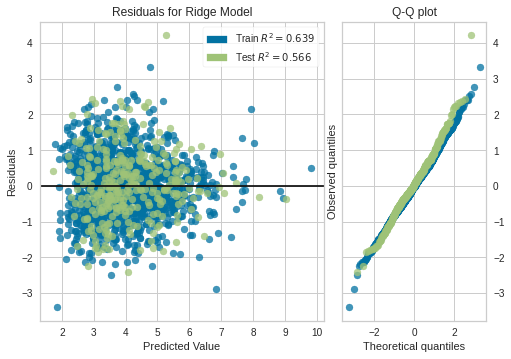

In [ ]:
# Plot des résidus
from yellowbrick.regressor import residuals_plot

visualizer = ResidualsPlot(Ridge_CV.best_estimator_, hist=False, qqplot=True)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

Rien de particulier à constater concernant la distribution des résidus du train et du test set.

#### Métriques

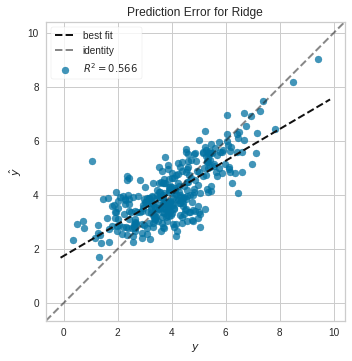

In [ ]:
# Plot des prédictions vs. valeurs
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(Ridge_CV.best_estimator_)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

Le modèle semble biaisé lorsqu'il s'agit de prédire des valeurs plus faibles des émissions de gaz à effet de serre.

In [ ]:
# MAE
y_pred = Ridge_CV.best_estimator_.predict(X_test_preprocessed)
Ridge_GHE_MAE = mean_absolute_error(y_test, y_pred)
Ridge_GHE_MAE

0.7268804583324338

In [ ]:
# Convertit en unité d'origine
np.expm1(Ridge_GHE_MAE)

1.0686173936291026

In [ ]:
# MAE pourcentage
mean_absolute_percentage_error(y_test, y_pred)

0.27602142136525165

## XGBoost regressor

### Optimisation des hyperparamètres

La régression Ridge étant un modèle ayant peu d'hyperparamètres (GridSearch rapide), et la regression d'XGBoost offrant des résultats similaires "out-of-the-box", je choisi d'également effectuer une GridSearch sur ce dernier.

De plus XGBoost n'est pas un modèle linéaire, contrairement à la régression Ridge, lui permettant ainsi de capturer de potentielles relations non linéaires entre la variable expliquée et les features.

GridSearch:
- par cross validation (5 folds)
- features utilisées: features du modèle XGB le plus performant out-of-the-box
- pas de log transformation de features (idem au modèle XGB le plus performant out-of-the-box)


In [ ]:
# Defini la selection de features
selection = df_metrics.loc[165]['Features']


# Defini les colonnes de la sélection à log-transformer, scaler et onehotencoder
to_var_log = list(np.intersect1d(var_log,X_train[selection].columns))
to_var_OHE = list(np.intersect1d(var_OHE,X_train[selection].columns))
to_var_cont = list(np.intersect1d(var_cont,X_train[selection].columns))

# Pas de log transformation
to_var_cont = to_var_cont + to_var_log
to_var_log = []

# Log transforme et scale une selection de colonnes
# Passage non affecté des autres colonnes
log_scaler = Pipeline([
                    ('log_transformer', FunctionTransformer(np.log1p)),
                    ('scaler', StandardScaler())
                    ])

# OHE sur une sélection de colonnes
# StandardScaler sur une selection de colonnes
# Log-transformation et StandardScaler sur une selection de colonnes
# Drop des colonnes non spécifiées
OHE_log_StandardScaler = ColumnTransformer(transformers=[
                                                        ('OHE', OneHotEncoder(drop='if_binary', sparse=False, handle_unknown="ignore"), to_var_OHE),
                                                        ('SCALER', StandardScaler(), to_var_cont),
                                                        ('LOG_SCALER', log_scaler, to_var_log)
                                                        ], remainder='drop')

# Imputation par KNN
imputer = KNNImputer(n_neighbors=5)


# Modèle le plus performant out-of-the-box
Best_model = XGB

# GridsearchCV
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.1, 0.15, 0.3],
    'max_depth': [3, 4, 5, 6],
    'reg_alpha': [0.5, 0],
    'reg_lambda': [1.1, 1.3, 1.5]
}

model_CV = GridSearchCV(Best_model, parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Assemblage du pipeline de preprocessing et fit du GridsearchCV
preprocessing_pipeline = Pipeline([
          ('OHE_log_StandardScaler', OHE_log_StandardScaler),
          ('imputer', imputer)
      ])

# Fit et application du pipeline
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train[selection])


model_CV.fit(X_train_preprocessed, y_train)

[22:51:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(random_state=1337), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15, 0.3],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200],
                         'reg_alpha': [0.5, 0], 'reg_lambda': [1.1, 1.3, 1.5]},
             scoring='neg_mean_absolute_error')

In [ ]:
# Meilleur estimateur de la CV
model_CV.best_estimator_.get_params

<bound method XGBModel.get_params of XGBRegressor(max_depth=4, n_estimators=150, random_state=1337, reg_lambda=1.3)>

In [ ]:
# Artéfacts de la CV
pd.DataFrame(model_CV.cv_results_).sort_values(by=['rank_test_score'], ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.618665,0.006103,0.003069,0.000103,0.1,4,150,0,1.3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.695333,-0.716689,-0.741929,-0.654850,-0.721466,-0.706054,0.029579,1
46,0.801353,0.007973,0.003739,0.000163,0.1,4,200,0,1.3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.691463,-0.722582,-0.745546,-0.655812,-0.717967,-0.706674,0.030692,2
111,0.473094,0.012636,0.003014,0.000411,0.15,3,150,0,1.1,"{'learning_rate': 0.15, 'max_depth': 3, 'n_est...",-0.706080,-0.711216,-0.744737,-0.661447,-0.716936,-0.708083,0.026872,3
127,0.422218,0.012242,0.002549,0.000138,0.15,4,100,0.5,1.3,"{'learning_rate': 0.15, 'max_depth': 4, 'n_est...",-0.699606,-0.710034,-0.756260,-0.646074,-0.728660,-0.708127,0.036511,4
19,0.655359,0.007402,0.003154,0.000120,0.1,3,200,0.5,1.3,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-0.699142,-0.711388,-0.742780,-0.660847,-0.728261,-0.708484,0.028044,5
37,0.616059,0.004106,0.004243,0.002295,0.1,4,150,0.5,1.3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.693291,-0.719669,-0.751915,-0.656421,-0.724203,-0.709100,0.032243,6
20,0.646591,0.010016,0.003224,0.000182,0.1,3,200,0.5,1.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-0.706822,-0.708399,-0.747973,-0.656180,-0.728558,-0.709586,0.030642,7
18,0.632748,0.008710,0.003122,0.000033,0.1,3,200,0.5,1.1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-0.701725,-0.712450,-0.749031,-0.657438,-0.727366,-0.709602,0.030533,8
43,0.814009,0.011241,0.003850,0.000226,0.1,4,200,0.5,1.3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.689176,-0.719341,-0.759960,-0.658310,-0.722791,-0.709915,0.034212,9
129,0.420778,0.013249,0.002570,0.000221,0.15,4,100,0,1.1,"{'learning_rate': 0.15, 'max_depth': 4, 'n_est...",-0.694184,-0.715496,-0.742616,-0.667352,-0.730506,-0.710031,0.026771,10


In [ ]:
# Dataframe des paramètres et score de la CV pour la présentation
XGB_GHE_ppt = pd.DataFrame(model_CV.cv_results_).sort_values(by=['rank_test_score'], ascending=True)[['param_learning_rate',	'param_max_depth',	'param_n_estimators',	'param_reg_alpha',	'param_reg_lambda', 'mean_test_score', 'mean_fit_time']]
XGB_GHE_ppt

,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,mean_test_score,mean_fit_time
40,0.1,4,150,0,1.3,-0.706054,0.618665
46,0.1,4,200,0,1.3,-0.706674,0.801353
111,0.15,3,150,0,1.1,-0.708083,0.473094
127,0.15,4,100,0.5,1.3,-0.708127,0.422218
19,0.1,3,200,0.5,1.3,-0.708484,0.655359
37,0.1,4,150,0.5,1.3,-0.709100,0.616059
20,0.1,3,200,0.5,1.5,-0.709586,0.646591
18,0.1,3,200,0.5,1.1,-0.709602,0.632748
43,0.1,4,200,0.5,1.3,-0.709915,0.814009
129,0.15,4,100,0,1.1,-0.710031,0.420778


In [ ]:
# Features du modele
df_metrics.loc[165]['Features']

['PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'Age',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'Neighborhood',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'MoreThanOneUse',
 'ENERGYSTARScore']

XGB semble performer au mieux avec de la régularisation, un nombre d'estimateurs relativement bas, ainsi qu'un learning rate faible.

### Evaluation du modèle

In [ ]:
# Application du pipeline au test set
X_test_preprocessed = preprocessing_pipeline.transform(X_test[selection])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


#### Résidus

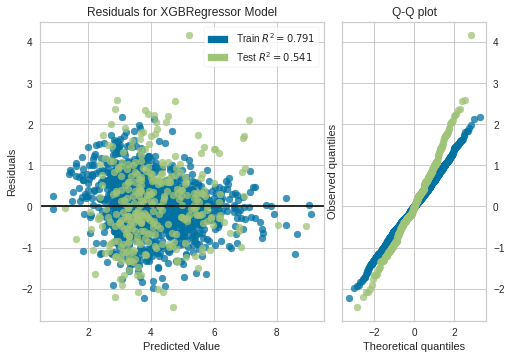

In [ ]:
# Plot des résidus
visualizer = ResidualsPlot(model_CV.best_estimator_, hist=False, qqplot=True)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

La distribution des résidus du test set diverge d'avantage d'une distribution normale que la distribution des résidus du training test.

#### Métriques

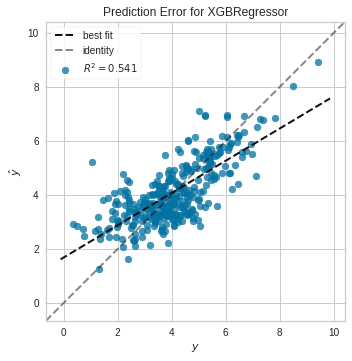

In [ ]:
# Prédictions vs. valeurs réelles (test set)
visualizer = PredictionError(model_CV.best_estimator_)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

Tout comme la régression Ridge, XGBoost semble prédire des valeurs plus élevées quand la varibale expliqué a une valeur faible.

In [ ]:
# MAE
y_pred = model_CV.best_estimator_.predict(X_test_preprocessed)
XGB_GHE_MAE = mean_absolute_error(y_test, y_pred)
XGB_GHE_MAE

0.7597640862254089

In [ ]:
# Convertit en unité d'origine
np.expm1(XGB_GHE_MAE)

1.1377718311810558

La régression XGBoost performe globalement moins bien sur les test set que le training set: il y a **surapprentissage**.

### Importance des features

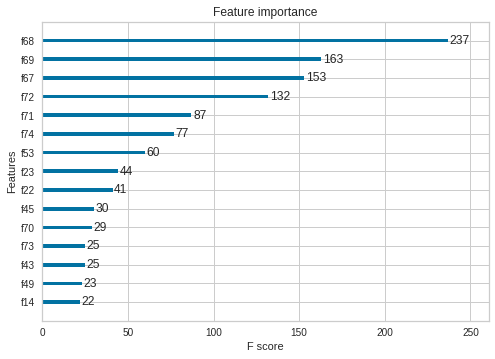

In [ ]:
# Plot des feature importances
xgb.plot_importance(model_CV.best_estimator_, max_num_features = 15)

En l'état, les pipelines sklearn ne permettent pas de récupérer les noms des features. Certaines étapes ne permettent pas de passer les noms des features: le FunctionTransformer utilisé pour la log-transformation, et le KNNimputer. 

L'ordre des colonnes et leur nombre étant modifié plusieurs fois dans le pipeline, il n'est pas possible de simplement récupérer les noms des features.

Je choisi de ne pas redévelopper les différentes étapes du pipeline car XGBoost ne sera pas le modèle sélectionné, et la régression Ridge n'a pas de feature importance.

### XGBoost vs. Ridge regression: Ridge l'emporte

In [ ]:
print('Erreur moyenne absolue de la régression Ridge:', Ridge_GHE_MAE)
print('Erreur moyenne absolue de la régression XGBoost:', XGB_GHE_MAE)

Erreur moyenne absolue de la régression Ridge: 0.7268804583324338
Erreur moyenne absolue de la régression XGBoost: 0.7597640862254089


Malgré davantage d'hyperparamètres à optimiser, la régression Ridge alliée à du feature engineering basique permet d'avoir une Erreur Moyenne Absolue moins importante sur le test set. Cela est en partie dû à un problème d'overfitting avec XGB.

Par conséquent: ***la régression ridge est le modèle retenu pour la prédiction des émissions de gaz à effet de serre.***

## Intérêt de l'ENERGYSTARScore comme feature du modèle

Pour évaluer l'intérêt de la feature ENERGYSTARScore, nous allons simplement analyser la performance du couple features-modèle le plus performant pour prédire les emissions de gaz à effet de serre, avec et sans l'ENERGYSTARScore.

Le modèle avec l'ENERGYSTARScore ayant déjà été entrainé et évalué, il ne reste plus qu'à réitérer le même processus en retirant l'ENERGYSTARScore des features.

On conserve le même pipeline, mais en gardant le seul hyperparamètre le plus performant (alpha, paramètre de régularisation) afin d'effectuer l'apprentissage en CV grace à l'étape GridSearchCV (5 folds):

In [ ]:
# Defini la selection de features
selection = ['PropertyGFATotal',
              'PropertyGFABuilding(s)',
              'Age',
              'MoreThanOneBuilding',
              'MoreThanOneFloor',
              'HasParking',
              'Longitude',
              'Latitude',
              'LargestPropertyUseType',
              'LargestPropertyUseTypeGFA',
              'MoreThanOneUse']


# Defini les colonnes de la sélection à log-transformer, scaler et onehotencoder
to_var_log = list(np.intersect1d(var_log,X_train[selection].columns))
to_var_OHE = list(np.intersect1d(var_OHE,X_train[selection].columns))
to_var_cont = list(np.intersect1d(var_cont,X_train[selection].columns))


# Log transforme et scale une selection de colonnes
# Passage non affecté des autres colonnes
log_scaler = Pipeline([
                    ('log_transformer', FunctionTransformer(np.log1p)),
                    ('scaler', StandardScaler())
                    ])

# OHE sur une sélection de colonnes
# StandardScaler sur une selection de colonnes
# Log-transformation et StandardScaler sur une selection de colonnes
# Drop des colonnes non spécifiées
OHE_log_StandardScaler = ColumnTransformer(transformers=[
                                                        ('OHE', OneHotEncoder(drop='if_binary', sparse=False, handle_unknown="ignore"), to_var_OHE),
                                                        ('SCALER', StandardScaler(), to_var_cont),
                                                        ('LOG_SCALER', log_scaler, to_var_log)
                                                        ], remainder='drop')

# Imputation par KNN
imputer = KNNImputer(n_neighbors=5)


# Modèle le plus performant out-of-the-box
Best_model = Ridge(random_state=1337)

# GridsearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[1.25]}

Ridge_CV = GridSearchCV(Best_model, parameters, scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)

# Assemblage du pipeline de preprocessing et fit du GridsearchCV
preprocessing_pipeline = Pipeline([
          ('OHE_log_StandardScaler', OHE_log_StandardScaler),
          ('imputer', imputer)
      ])

# Fit et application du pipeline
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train[selection])


Ridge_CV.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=1337), n_jobs=-1,
             param_grid={'alpha': [1.25]}, scoring='neg_mean_absolute_error')

In [ ]:
# Hyperparamètres et métriques
Ridge_GHE_noScore_ppt = pd.DataFrame(Ridge_CV.cv_results_).sort_values(by=['rank_test_score'], ascending=True)[['param_alpha', 'mean_test_score', 'mean_score_time']]
Ridge_GHE_noScore_ppt

,param_alpha,mean_test_score,mean_score_time
0,1.25,-0.735039,0.000614


In [ ]:
# Application du pipeline de preprocessing au test set
X_test_preprocessed = preprocessing_pipeline.transform(X_test[selection])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


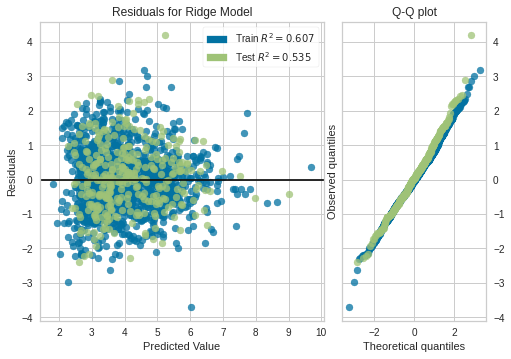

In [ ]:
# Plots des résidus pour test et train sets
visualizer = ResidualsPlot(Ridge_CV.best_estimator_, hist=False, qqplot=True)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

In [ ]:
# MAE
y_pred = Ridge_CV.best_estimator_.predict(X_test_preprocessed)
Ridge_noScore_GHE_MAE = mean_absolute_error(y_test, y_pred)

In [ ]:
# Convertit en unité d'origine
np.expm1(Ridge_noScore_GHE_MAE)

1.1413332621629226

In [ ]:
print('Erreur moyenne absolue de la régression Ridge avec ENERGYSTARScore:', Ridge_GHE_MAE)
print('Erreur moyenne absolue de la régression Ridge sans ENERGYSTARScore:', Ridge_noScore_GHE_MAE)

Erreur moyenne absolue de la régression Ridge avec ENERGYSTARScore: 0.7268804583324338
Erreur moyenne absolue de la régression Ridge sans ENERGYSTARScore: 0.7614286547398571


L'ENERGYSTARSCore semble être une **variable pertinente**: la MAE est plus faible avec le score en feature. (Nb. le modèle performe mieux)

# Prédiction de la consommation totale d’énergie

La methode et le code utilisés pour l'entrainement et la prédiction de la consommation totale d'énergie est le même que pour les émissions de gaz à effet de serre.

La seule **différence est la mise de côte de l'ENERGYSTARScore**. En effet, ce score étant basé en partie sur les relevés de consommations d'énergies, l'utiliser dans les features du modèle entrainerait une **fuite de données**. 

## Split des données: jeux d'entrainement et de test

In [ ]:
# Constitution du set d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X,y_En, test_size=0.2, 
                                                    #stratify=X["discretized_GFATotal"], 
                                                    random_state=42)

# Log des variables à expliquer
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

## Recherche du meilleur modèle

In [ ]:
# Instancie le Dataframe à append par la fonction train_test_cv
df_metrics = pd.DataFrame()

# Loop sur toutes les options prédéfinies
for model in model_list:
  for label_a, a in Cont_vs_dummies.items():
    for label_b, b in Geo_var.items():
      for label_c, c in UGFA_vs_largestusage.items():
        for label_e, e in log_tran.items():
          train_test_cv(X_train, Commun+a+b+c, y_train, model, e, df_metrics, '_'.join([label_a, label_b, label_c]))

[22:53:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# Différentes combinaisons de features-modèles par ordre d'erreur moyenne absolue décroissante
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_metrics.sort_values(by=['neg_mean_absolute_error'], ascending=False)

,Features,Log Transformation,Model,R²,fit_time,label,neg_mean_absolute_error,neg_mean_absolute_percentage_error,neg_mean_squared_error
30,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),4.856000e-01,0.0080,Dummies_Lon_lat_LargestUsage,-6.202000e-01,-3.450100e+14,-1.598400e+00
22,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),4.848000e-01,0.0030,Continues_Lon_lat_LargestUsage,-6.204000e-01,-3.446441e+14,-1.598400e+00
95,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",0.0,XGBRegressor(random_state=1337),4.400000e-01,0.1852,Dummies_Lon_lat_LargestUsage,-6.274000e-01,-3.514656e+14,-1.731000e+00
94,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),4.400000e-01,0.1830,Dummies_Lon_lat_LargestUsage,-6.274000e-01,-3.514656e+14,-1.731000e+00
83,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",0.0,XGBRegressor(random_state=1337),4.532000e-01,0.1956,Continues_Neighborhood_LargestUsage,-6.286000e-01,-3.501257e+14,-1.685200e+00
82,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),4.532000e-01,0.1964,Continues_Neighborhood_LargestUsage,-6.288000e-01,-3.501257e+14,-1.685200e+00
87,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",0.0,XGBRegressor(random_state=1337),4.412000e-01,0.1806,Continues_Lon_lat_LargestUsage,-6.302000e-01,-3.513081e+14,-1.729800e+00
86,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),4.412000e-01,0.1814,Continues_Lon_lat_LargestUsage,-6.304000e-01,-3.513081e+14,-1.729800e+00
18,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,Ridge(random_state=1337),4.638000e-01,0.0058,Continues_Neighborhood_LargestUsage,-6.356000e-01,-3.499230e+14,-1.657400e+00
90,"[PropertyGFATotal, PropertyGFABuilding(s), Age...",1.0,XGBRegressor(random_state=1337),4.480000e-01,0.1956,Dummies_Neighborhood_LargestUsage,-6.360000e-01,-3.526235e+14,-1.712400e+00


Là encore, la régression Ridge avec log-transformation de certaines features performe le mieux.

- Tous les modèles linaires performent mieux en moyenne après log-transformation d'un set de features feed au modèle (particulièrement les régression Ridge et Elasticnet)
- La regression Ridge outperform même les modèles ensemblistes non linéaires (XGBoost et RandomForest)
- La log-transformation ne semble pas avoir d'impact particulier sur ces modèles ensemblistes


***Le modèle retenu pour la prédiction de consommation totale d'énergie est la régression Ridge.***

## Ridge regression

En suivant la même démarche que précedemment, nous allons chercher la valeur de paramètre alpha dans une GridSearch apportant la meilleure performance moyenne (en terme de MAE) sur les 5 "folds" de la cross-validation.

### Optimisation des hyperparamètres

In [ ]:
# Features utilisées dans le modèle le plus performant
df_metrics.loc[30]['Features']

['PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'Age',
 'MoreThanOneBuilding',
 'MoreThanOneFloor',
 'HasParking',
 'Longitude',
 'Latitude',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'MoreThanOneUse']

In [ ]:
# Defini la selection de features
selection = df_metrics.loc[30]['Features']


# Defini les colonnes de la sélection à log-transformer, scaler et onehotencoder
to_var_log = list(np.intersect1d(var_log,X_train[selection].columns))
to_var_OHE = list(np.intersect1d(var_OHE,X_train[selection].columns))
to_var_cont = list(np.intersect1d(var_cont,X_train[selection].columns))


# Log transforme et scale une selection de colonnes
# Passage non affecté des autres colonnes
log_scaler = Pipeline([
                    ('log_transformer', FunctionTransformer(np.log1p)),
                    ('scaler', StandardScaler())
                    ])

# OHE sur une sélection de colonnes
# StandardScaler sur une selection de colonnes
# Log-transformation et StandardScaler sur une selection de colonnes
# Drop des colonnes non spécifiées
OHE_log_StandardScaler = ColumnTransformer(transformers=[
                                                        ('OHE', OneHotEncoder(drop='if_binary', sparse=False, handle_unknown="ignore"), to_var_OHE),
                                                        ('SCALER', StandardScaler(), to_var_cont),
                                                        ('LOG_SCALER', log_scaler, to_var_log)
                                                        ], remainder='drop')

# Imputation par KNN
imputer = KNNImputer(n_neighbors=5)


# Modèle le plus performant out-of-the-box
Best_model = Ridge(random_state=1337)

# GridsearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.4, 1.5, 2, 2.5]}

Ridge_CV = GridSearchCV(Best_model, parameters, scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)

# Assemblage du pipeline de preprocessing et fit du GridsearchCV
preprocessing_pipeline = Pipeline([
          ('OHE_log_StandardScaler', OHE_log_StandardScaler),
          ('imputer', imputer)
      ])

# Fit et application du pipeline
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train[selection])


Ridge_CV.fit(X_train_preprocessed, y_train)


GridSearchCV(cv=5, estimator=Ridge(random_state=1337), n_jobs=-1,
             param_grid={'alpha': [0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.4, 1.5, 2,
                                   2.5]},
             scoring='neg_mean_absolute_error')

In [ ]:
# DataFrame pour tous les alphas
Ridge_En_ppt = pd.DataFrame(Ridge_CV.cv_results_).sort_values(by=['rank_test_score'], ascending=True)[['param_alpha', 'mean_test_score', 'mean_score_time']]
Ridge_En_ppt

,param_alpha,mean_test_score,mean_score_time
9,2.5,-0.618393,0.000754
8,2,-0.618708,0.000865
7,1.5,-0.619337,0.000716
6,1.4,-0.619505,0.000671
5,1.25,-0.619785,0.000684
4,1.1,-0.620085,0.000662
3,1,-0.620313,0.000741
2,0.9,-0.620575,0.001112
1,0.75,-0.621070,0.000998
0,0.5,-0.622088,0.001228


In [ ]:
# Alpha apportant la meilleure performance sur le train set
Ridge_CV.best_estimator_

Ridge(alpha=2.5, random_state=1337)

### Evaluation du modèle

In [ ]:
# Application du pipeline de preprocessing au test set
X_test_preprocessed = preprocessing_pipeline.transform(X_test[selection])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


#### Résidus

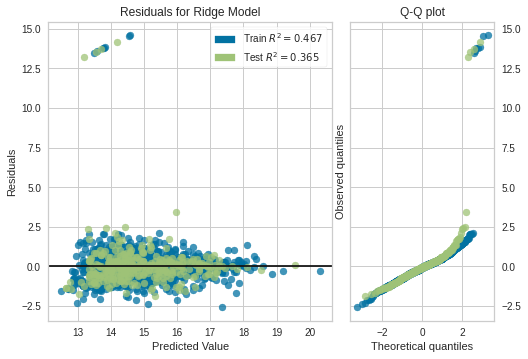

In [ ]:
# Résidus
visualizer = ResidualsPlot(Ridge_CV.best_estimator_, hist=False, qqplot=True)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

#### Métriques

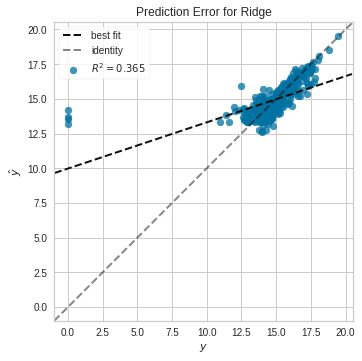

In [ ]:
# Prédictions vs. valeurs réelles du test set
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(Ridge_CV.best_estimator_)
visualizer.fit(X_train_preprocessed, y_train)
visualizer.score(X_test_preprocessed, y_test)
visualizer.show()

In [ ]:
# MAE
y_pred = Ridge_CV.best_estimator_.predict(X_test_preprocessed)
mean_absolute_error(y_test, y_pred)

0.7130437049953553

In [ ]:
# Convertit en unité d'origine
np.expm1(mean_absolute_error(y_test, y_pred))

1.0401915591573174

Le **R² est plus bas** que pour les prédictions des émissions de gaz à effet de serre.

Le modèle **performe moins quand il s'agit de prédire les valeurs les plus faible** de la variable à expliquer, et ce pour le training set et le test set, comme on peut le constater sur les deux graphiques ci-dessus.

# Conclusions

Sur ces deux problèmes de prédiction, et avec du feature engineering (**log-transformation**), l**a régression Ridge performe mieux** que des modèles ensemblistes non linéaires tels qu'XGBoost. **XGBoost a tendance à surapprendre** le dataset, et cela même en limitant certains paramètres et en utilisant de la régularisation.

In fine, **aucun modèle n'offre de très bonnes performances**, que ce soit en termes d'erreur ou de variance expliquée (environ 50% sur le test set au mieux). 

Le **volume de données étant assez faible**, tant en nombre d'observations qu'en nombre de features, pourrait constituer une piste majeure d'amélioration.
